In [1]:
import sys

import numpy as np
np.set_printoptions(suppress = True)
import qiskit as qk
from qiskit import Aer, ClassicalRegister
from qiskit.tools.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
import time
from qiskit import QuantumCircuit

In [2]:
def ZeroAncCRn(circuit, control, target, theta):
    circuit.p(theta/2, control)
    circuit.p(theta/2, target)
    circuit.cnot(control, target)
    circuit.p(-theta/2, target)
    circuit.cnot(control, target)

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit


In [3]:

def AFTerror(qc2, n, qft_probs, delta, backend="statevector", display_bool=False):
    # returns a correlation coefficient between the qft and aft signals
    aft_probs = simulate(qc2, n, display_bool=display_bool, delta=delta, backend=backend)
    mae = np.abs(np.subtract(qft_probs, aft_probs)).mean()
    return mae

def compareAFT(n, max_delta, qft_counts, display_bool=False, backend="statevector"):
    errors = []
    deltas = []
    for d in range(1, max_delta, 1):
        deltas.append(d)
        print("progress: {:.2f}%".format(d/n*100))
        qcAFT = QuantumCircuit(n, n)
        qcAFT.h(n//2)
        QFT(qcAFT, n, delta=d)
        errors.append(AFTerror(qcAFT, n, qft_counts, d, backend=backend, display_bool=display_bool))

    assert len(deltas) == len(errors)
    return deltas, errors

def QFT(circuit, n, delta=10000):
    swap_registers(circuit, n)
    for i in range(n):
        circuit.h(i)
        for j in range(1, n-i):
            if j < delta:
                ZeroAncCRn(circuit, i+j, i, np.pi/2**(j))
            else:
                break

In [4]:
def simulate(qc, n, reps=2**14, display_bool=False, delta=10000, backend="statevector",
    noise = 0.01):
    # Create an empty noise model
    noise_model = NoiseModel()

    # Add depolarizing error to all single qubit u1, u2, u3 gates
    error = depolarizing_error(noise, 1)
    noise_model.add_all_qubit_quantum_error(error, ['h', 't', 'cnot', 'tdg', 'p'])

    # Print noise model info
    # print(noise_model)

    if backend == "simulator":
        qc.measure(range(n), range(n))
        # simulator = Aer.get_backend('qasm_simulator')
        simulator = AerSimulator(noise_model=noise_model)
        job_sim = simulator.run(qk.transpile(qc, simulator), shots=reps)
        result_sim = job_sim.result()
        counts = (result_sim.get_counts(qc))
        if display_bool:
            # choose appropriate filename
            filename = "charts/n={},delta={},noise={}.png".format(n, delta if delta < 9000 else "infinite", noise)
            plot_histogram(counts, legend=[], bar_labels=False, title="n={}, delta={}".format(n, delta if delta < 9000 else "infinite"), filename=filename)
            hist = plot_histogram(counts, legend=[], bar_labels=False, title="n={}, delta={}".format(n, delta if delta < 9000 else "infinite"))
            display(hist)
        return counts


    elif backend == "statevector":
        # qc.measure(range(n), range(n))
        backend = Aer.get_backend('statevector_simulator') # the device to run on
        result = backend.run(qk.transpile(qc, backend)).result()
        psi  = result.get_statevector(qc)

        probs = psi.probabilities()
        if display_bool:
            filename = "charts/probabilities,n={},delta={}.png".format(n, delta if delta < 9000 else "infinite")
            plt.bar([x for x in range(2**n)], probs, color="#c888e3")
            plt.title("n={}, delta={}".format(n, delta if delta < 9000 else "infinite"))
            plt.show()
            plt.savefig(filename)
        return probs[:2**n]

In [6]:
b = 3
qasm_qc = QuantumCircuit(b, b)
QFT(qasm_qc, b, delta=8)
qasm_output = qasm_qc.qasm()

In [7]:
with open("qasm_files/qasm{}qubit".format(b), 'w') as txt_file:
    txt_file.write(qasm_output)

In [88]:
def compareFTs(n_low, n_high, backend="statevector", display_bool=False):

    filename = 'errors{}-{}.txt'.format(n_low, n_high)
    print(filename)
    f = open('txt/{}'.format(filename), 'w')
    f.write("n, delta, error\n")

    i = 0
    for n in range(n_low, n_high+1, 1):
        print("n={}, i={}".format(n, i))
        qcQFT = QuantumCircuit(n, n)
        qcQFT.h(n//2)
        QFT(qcQFT, n)
        qft_probs = simulate(qcQFT, n, display_bool=display_bool, backend=backend)
        start_time = time.time()
        deltas, errors = compareAFT(n, n, qft_probs, backend=backend, display_bool=display_bool)
        print("--- {:.3f}s seconds ---".format(time.time() - start_time))
        for d in range(len(deltas)):
            f = open('txt/{}'.format(filename), 'a')
            f.write("{}, {}, {}\n".format(n, deltas[d], errors[d]))
            f.close()
        i -=- 1

    f.close()

n_low = 2
n_high = 20
compareFTs(n_low, n_high, backend="statevector", display_bool=False)

errors2-20.txt
n=2, i=0
progress: 50.00%
--- 0.011985063552856445 seconds ---
n=3, i=1
progress: 33.33%
progress: 66.67%
--- 0.040000200271606445 seconds ---
n=4, i=2
progress: 25.00%
progress: 50.00%
progress: 75.00%
--- 0.09701824188232422 seconds ---
n=5, i=3
progress: 20.00%
progress: 40.00%
progress: 60.00%
progress: 80.00%
--- 0.17298603057861328 seconds ---
n=6, i=4
progress: 16.67%
progress: 33.33%
progress: 50.00%
progress: 66.67%
progress: 83.33%
--- 0.2965571880340576 seconds ---
n=7, i=5
progress: 14.29%
progress: 28.57%
progress: 42.86%
progress: 57.14%
progress: 71.43%
progress: 85.71%
--- 0.48802924156188965 seconds ---
n=8, i=6
progress: 12.50%
progress: 25.00%
progress: 37.50%
progress: 50.00%
progress: 62.50%
progress: 75.00%
progress: 87.50%
--- 0.7488551139831543 seconds ---
n=9, i=7
progress: 11.11%
progress: 22.22%
progress: 33.33%
progress: 44.44%
progress: 55.56%
progress: 66.67%
progress: 77.78%
progress: 88.89%
--- 1.2231647968292236 seconds ---
n=10, i=8
prog

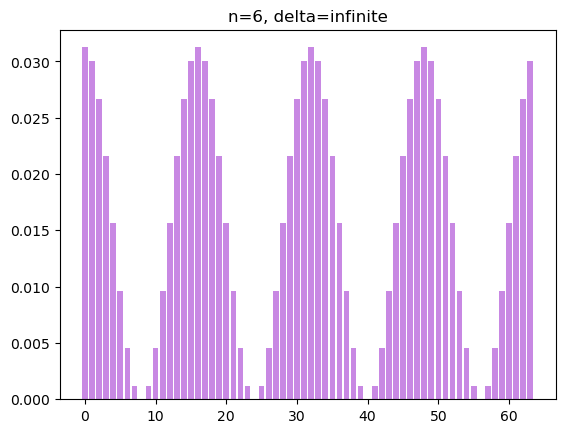

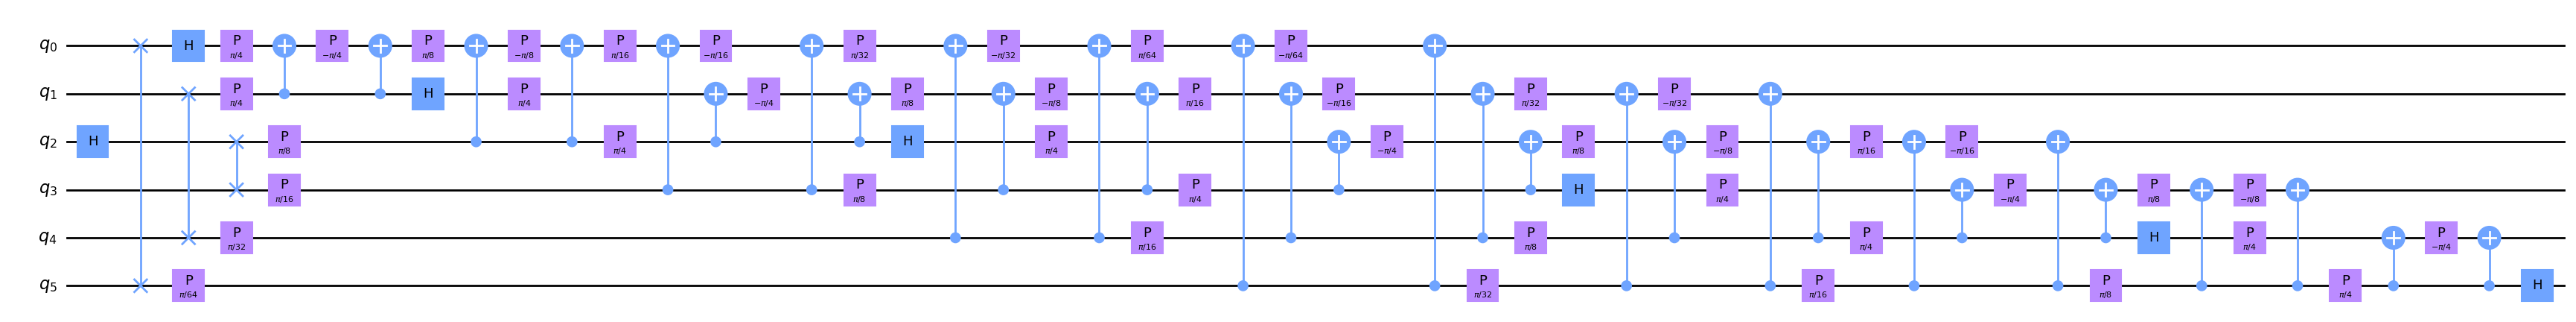

<Figure size 640x480 with 0 Axes>

In [59]:
n = 6
ac = QuantumCircuit(n)
ac.h(2)
QFT(ac, n)

probs = simulate(ac, n, display_bool=True)

ac.draw(output="mpl", fold=-1)

min_n = 2, max_n = 21, min_d = 1, max_d = 20
(21, 20)
x = 2, y = 1, data = 1.6697788640876683e-34
x = 3, y = 1, data = 0.06250000000000006
x = 3, y = 2, data = 0.0
x = 4, y = 1, data = 0.03125000000000003
x = 4, y = 2, data = 3.469446951953614e-18
x = 4, y = 3, data = 6.938893903907228e-18
x = 5, y = 1, data = 0.023437500000000014
x = 5, y = 2, data = 0.007812500000000014
x = 5, y = 3, data = 3.7947076036992655e-18
x = 5, y = 4, data = 5.095750210681871e-18
x = 6, y = 1, data = 0.01171875000000001
x = 6, y = 2, data = 0.003906250000000007
x = 6, y = 3, data = 5.8817967857338616e-18
x = 6, y = 4, data = 6.152847328855238e-18
x = 6, y = 5, data = 1.734723475976807e-18
x = 7, y = 1, data = 0.006835937500000006
x = 7, y = 2, data = 0.002929687500000008
x = 7, y = 3, data = 0.0009765625000000043
x = 7, y = 4, data = 2.930733997499879e-18
x = 7, y = 5, data = 1.9786689647860456e-18
x = 7, y = 6, data = 1.2536087619363645e-18
x = 8, y = 1, data = 0.003417968750000003
x = 8, y = 2, data = 0.00

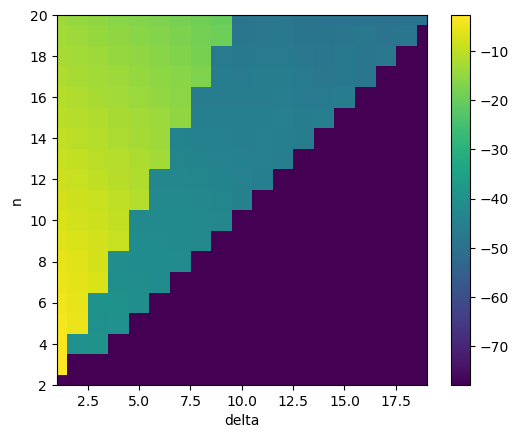

In [94]:
from numpy import genfromtxt
my_data = genfromtxt('txt/errors2-20.txt', delimiter=',')
my_data = my_data[1:,:]

max_n = np.max(my_data[:, 0]).astype(int) + 1
max_d = np.max(my_data[:, 1]).astype(int) + 1
min_n = np.min(my_data[:, 0]).astype(int)
min_d = np.min(my_data[:, 1]).astype(int)

print("min_n = {}, max_n = {}, min_d = {}, max_d = {}".format(min_n, max_n, min_d, max_d))
errors = np.zeros((max_n, max_d))# + sys.float_info.min
print(errors.shape)

for datum in my_data:
    n = datum[0].astype(int)
    d = datum[1].astype(int)
    print("x = {}, y = {}, data = {}".format(n, d, datum[2]))
    errors[n][d] = datum[2]

# errors = errors[min_n:,min_d:]
ma = errors[errors != 0]
errors += np.min(ma)
print(errors)
plt.imshow(np.log(errors))
ax = plt.gca()
ax.invert_yaxis()
ax.set_ylim(min_n, max_n - 1)
ax.set_ylabel("n")
ax.set_xlim(min_d, max_d - 1)
ax.set_xlabel("delta")

plt.colorbar()